## San Francisco Crime Analysis, Summer 2014

##### Adam Acosta

In [2]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

## Data Description

The dataset is available here:

[San Francisco Summer 2014 Crime Dataset](https://github.com/uwescience/datasci_course_materials/blob/master/assignment6/sanfrancisco_incidents_summer_2014.csv)

This contains a record of every incident report filed from June through September 2014 in the city of San Francisco. First, we'll load the data to begin the analysis.

In [4]:
sf_crime = pd.read_csv('sanfrancisco_incidents_summer_2014.csv', parse_dates=[4], index_col=['Date', 'Time'], 
                       dtype={'Category': pd.Categorical, 'Descript': pd.Categorical, 
                              'DayOfWeek': pd.Categorical, 'PdDistrict': pd.Categorical})

# Remove redundant columns, i.e. location on top of X, Y
# Also remove non-crime incident reports
sf_crime = sf_crime.ix[sf_crime['Category'] != 'NON-CRIMINAL', :9]
def parse_time(st):
    h, m = st.split(':')
    return datetime.time(hour=int(h))
sf_crime['Hour'] = sf_crime.index.get_level_values(1)
sf_crime['Hour'] = sf_crime['Hour'].apply(parse_time)

## Overview

We analyze the trends in the reports and find that the most likely to occur is larceny, and when combined with robbery and auto theft, general theft especially overwhelms all other crime. Additionally, most crime occurs in the early evening, though violent crime, assaults and robberies, tend to remain high until midnight. Finally, much of the crime is concentrated in a few districts, in particular the Southern district, which also contrinbut

## Crime by Time of Day

We can break this into several sub-questions. First, does crime overall vary by time of day? We can see below that it clearly does, peaking in the early evening, then dropping steadily until about 3 AM, where it bottoms out, following the expected sleep/wake pattern of a typical person. 

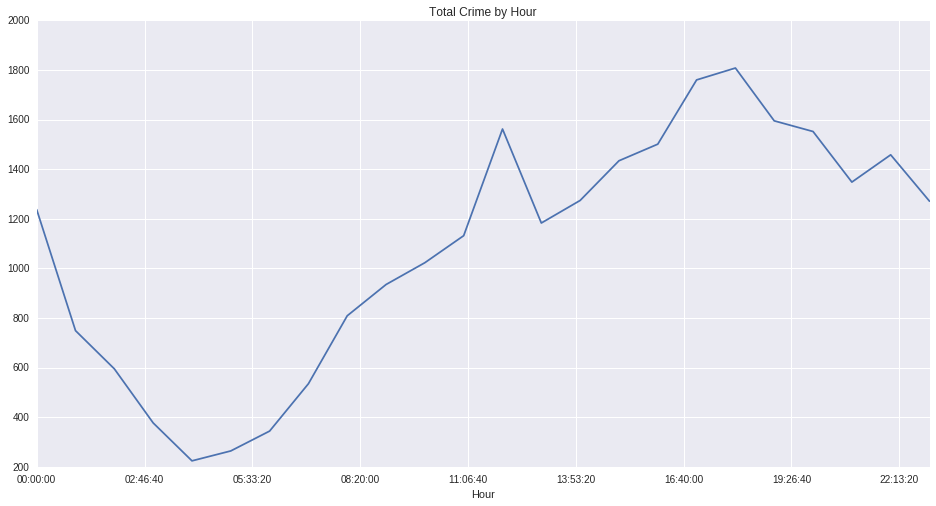

In [5]:
pd.DataFrame(
    sf_crime.groupby('Hour')['Category'].value_counts()
).sum(
    level=0
).plot(figsize=(16, 8), legend=False, title='Total Crime by Hour')

Then we can drill down further to ask about specific times of crime. Here, given the available categories, we'll classify robbery and assault as violent crimes, to see if the pattern is any different. We find it is, with multiple peaks. The first peak occurs around the same time as the peak for all crime, but then we get another peak around 10 PM and another peak at midnight. Further, there is a lower peak, but still a noticeable spike, right around noon. It's not clear what the cause of this is, but worth investigating.

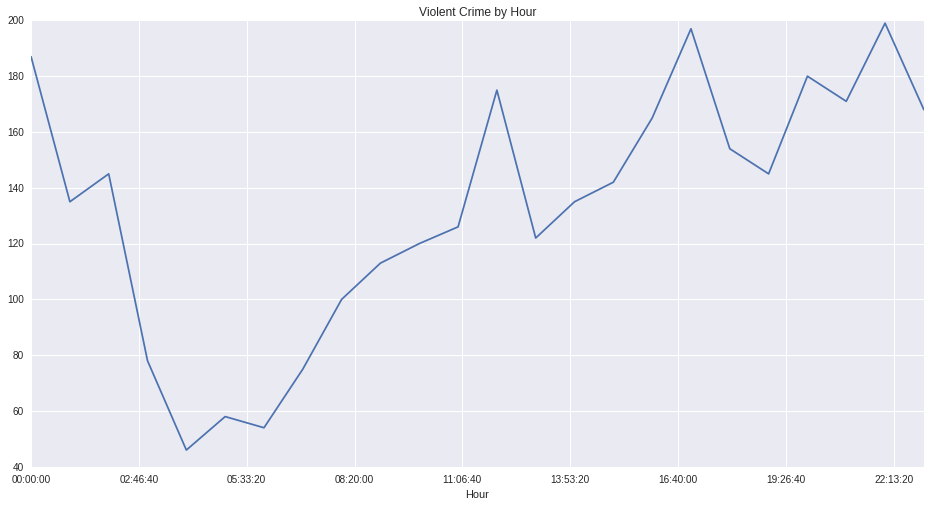

In [6]:
pd.DataFrame(
    sf_crime.query(
        "Category in ['ROBBERY', 'ASSAULT']"
    ).groupby('Hour')['Category'].value_counts().sum(level=0)
).plot(figsize=(16, 8), legend=False, title='Violent Crime by Hour')

Next, we drill down even further to examine specific categories. Nothing much seems to stand out here, except that it becomes apparent that, of all crimes, larceny/theft is far more common than any other. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f80aa74b250>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f80aa3b5290>]], dtype=object)

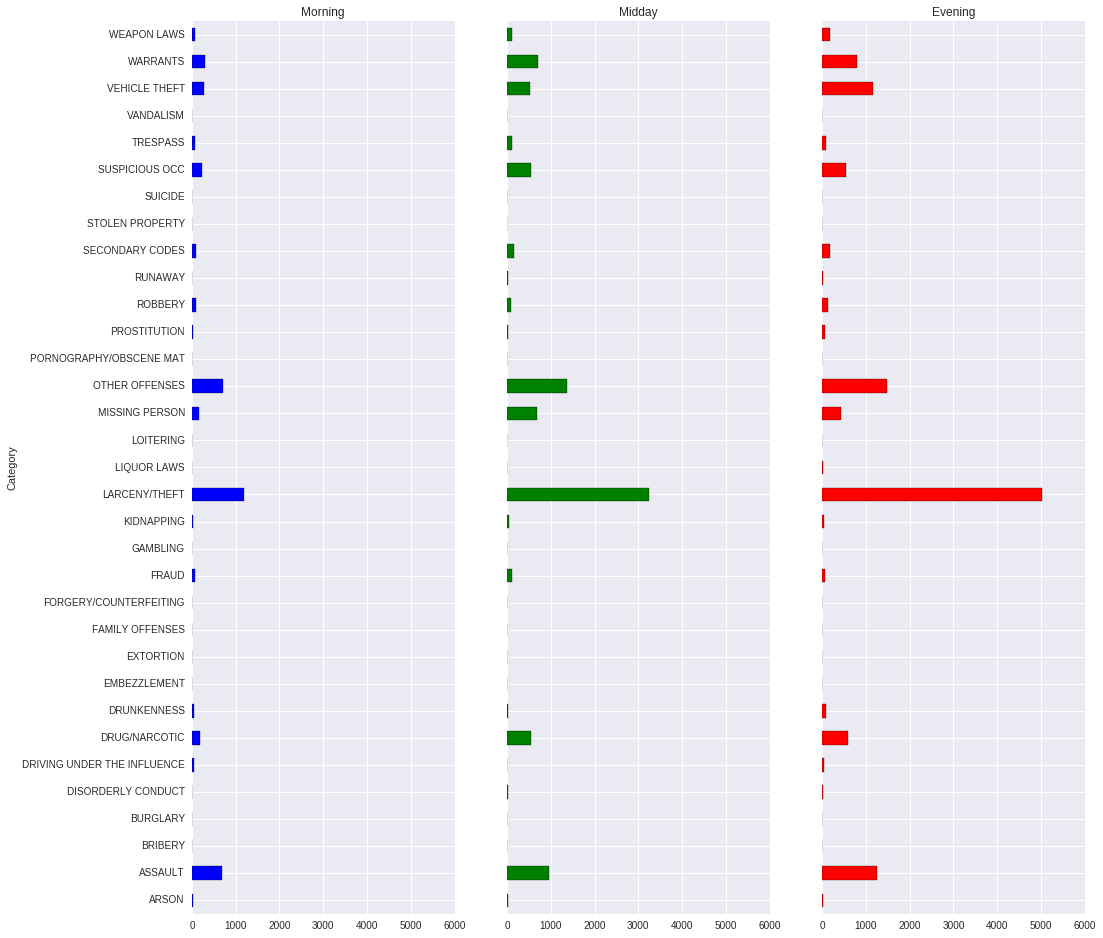

In [7]:
pd.DataFrame(
    pd.DataFrame(
        data={'Hour': pd.cut([h.hour for h in sf_crime['Hour']], bins=3),
              'Category': pd.Categorical(sf_crime['Category'])}
    ).reset_index().set_index('Hour').groupby(level=0)['Category'].value_counts()
).reset_index().pivot(
    index='Category', columns='Hour', values=0
).fillna(0).rename(
    columns={'(-0.023, 7.667]': 'Morning', '(7.667, 15.333]': 'Midday', '(15.333, 23]': 'Evening'}
).plot(kind='barh', legend=False, subplots=True, layout=(1, 3), figsize=(16, 16), sharex=True, sharey=True)

## Total Crime throughout the Summer

If we consider all crime plotted as a time series with the daily total on the y-axis, we see a few distinct peaks, most notable in early and late June, then again in early August. There is also a small, but noticeable overall upward trend, though it is not clear this is distinct from random drift.

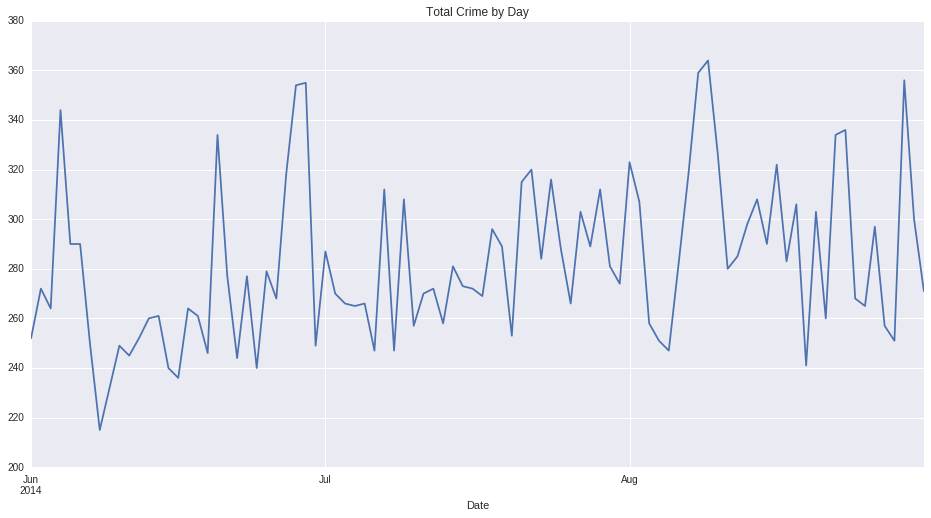

In [8]:
pd.DataFrame(
    sf_crime.groupby(level=0)['Category'].value_counts()
).sum(
    level=0
).plot(figsize=(16, 8), legend=False, title='Total Crime by Day')

We can break down these totals into neighborhood totals, dividing into low and high-crime districts, to see the contributions of each to the citywide total. We can see here that the peaks we observed above are mostly due to one district, the Southern, with the late June peak coming somewhat from the Mission as well. 

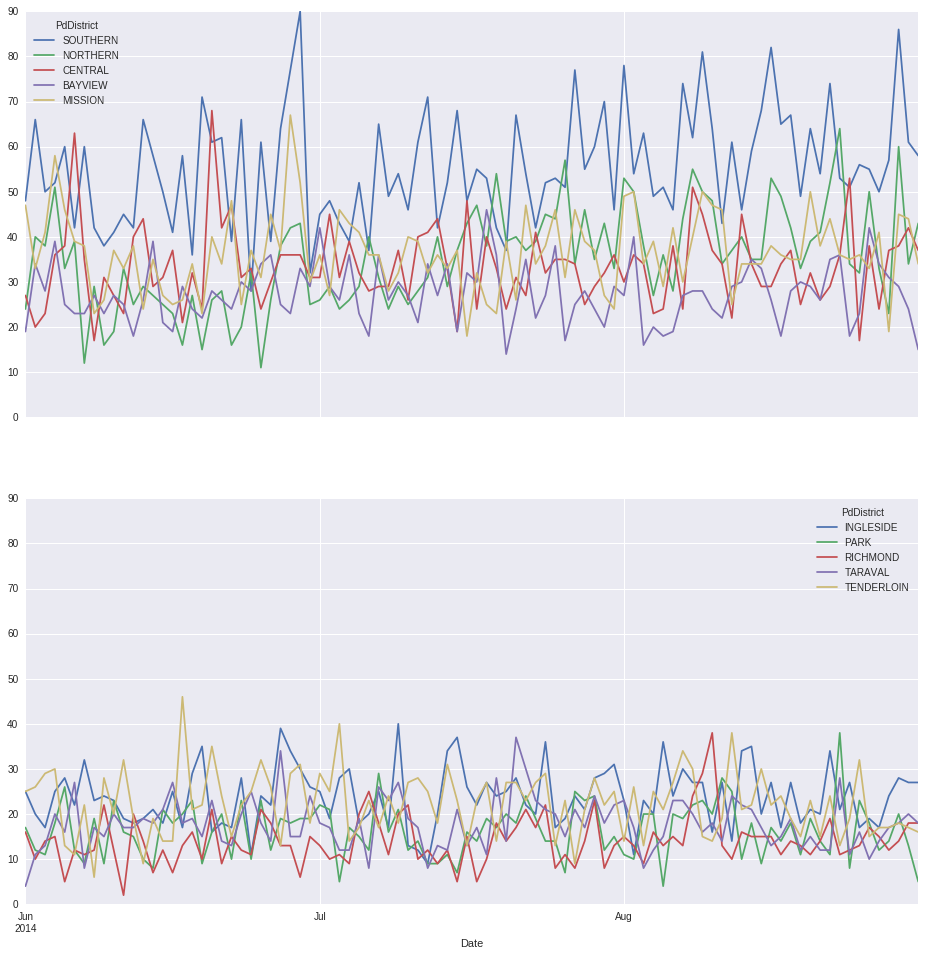

In [9]:
all_dist = pd.DataFrame(
    sf_crime.groupby(level=0)['PdDistrict'].value_counts()
).reset_index().set_index('Date').pivot(
    columns='PdDistrict', values=0
)
all_dist.head()
high_crime = all_dist[['SOUTHERN', 'NORTHERN', 'CENTRAL', 'BAYVIEW', 'MISSION']]
low_crime = all_dist[['INGLESIDE', 'PARK', 'RICHMOND', 'TARAVAL', 'TENDERLOIN']]

fig, ax = plt.subplots(2, 1, figsize=(16, 16), sharex=True, sharey=True)
for i, df in enumerate([high_crime, low_crime]):
    df.plot(ax=ax[i])

Finally, if we simply aggregate these numbers into totals for the entire summer, we see much the same thing. The Southern district accounts for more than twice the crime of all five individual neighborhoods we have classified as 'low crime.' 

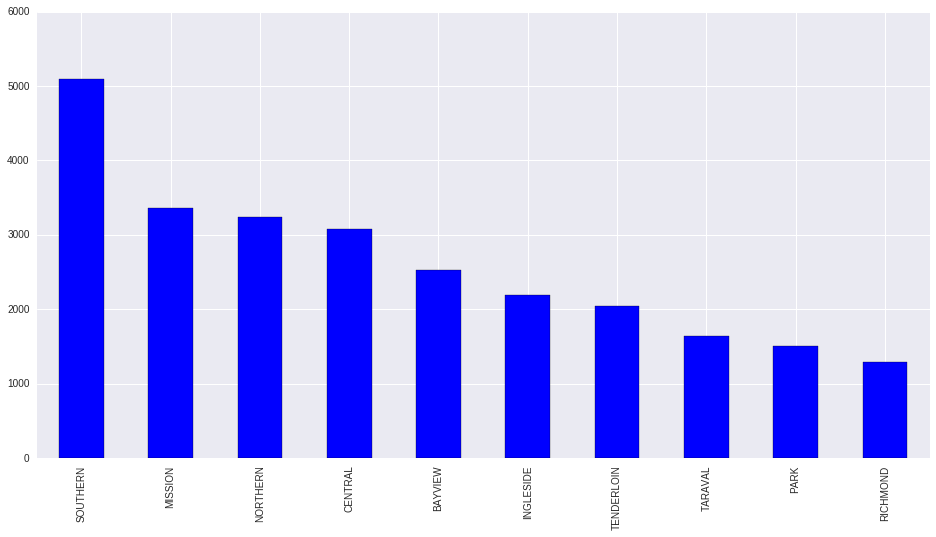

In [10]:
sf_crime['PdDistrict'].value_counts().plot(kind='bar', figsize=(16, 8))